# TP : Word Embeddings for Classification


## Authors:

- Gabriele LORENZO
- Aldo PIETROMATERA


## Objectives:

Explore the various way to represent textual data by applying them to a relatively small French classification dataset based on professionnal certification titles - **RNCP** - and evaluate how they perform on the classification task.

1. Using what we have previously seen, pre-process the data: clean it, obtain an appropriate vocabulary.
2. Obtain representations: any that will allow us to obtain a vector representation of each document is appropriate.
   - Symbolic: **BoW, TF-IDF**
   - Dense document representations: via **Topic Modeling: LSA, LDA**
   - Dense word representations: **SVD-reduced PPMI, Word2vec, GloVe**
     - For these, you will need to implement a **function aggregating word representations into document representations**
3. Perform classification: we can make things simple and only use a **logistic regression**


## Necessary dependancies

We will need the following packages:

- The Machine Learning API Scikit-learn : http://scikit-learn.org/stable/install.html
- The Natural Language Toolkit : http://www.nltk.org/install.html
- Gensim: https://radimrehurek.com/gensim/

These are available with Anaconda: https://anaconda.org/anaconda/nltk and https://anaconda.org/anaconda/scikit-learn


In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pprint
import pandas as pd

from sklearn.metrics import classification_report

pp = pprint.PrettyPrinter(indent=3)

## Loading data

Let's load the data: take a first look.


In [2]:
with open("./data/rncp.csv", encoding="utf-8") as f:
    rncp = pd.read_csv(f, na_filter=False)

print(rncp.head())

   Categorie                                text_certifications
0          1  Responsable de chantiers de bûcheronnage manue...
1          1  Responsable de chantiers de bûcheronnage manue...
2          1                                 Travaux forestiers
3          1                                              Forêt
4          1                                              Forêt


In [3]:
print(rncp.columns.values)
texts = rncp.loc[:, "text_certifications"].astype("str").tolist()
labels = rncp.loc[:, "Categorie"].astype("str").tolist()

['Categorie' 'text_certifications']


You can see that the first column is the category, the second the title of the certification. Let's get the category names for clarity:


In [4]:
Categories = [
    "1-environnement",
    "2-defense",
    "3-patrimoine",
    "4-economie",
    "5-recherche",
    "6-nautisme",
    "7-aeronautique",
    "8-securite",
    "9-multimedia",
    "10-humanitaire",
    "11-nucleaire",
    "12-enfance",
    "13-saisonnier",
    "14-assistance",
    "15-sport",
    "16-ingenierie",
]

In [5]:
pp.pprint(texts[:10])

[  'Responsable de chantiers de bûcheronnage manuel et de débardage',
   'Responsable de chantiers de bûcheronnage manuel et de sylviculture',
   'Travaux forestiers',
   'Forêt',
   'Forêt',
   'Responsable de chantiers forestiers',
   'Diagnostic et taille des arbres',
   'option Chef d’entreprise ou OHQ en travaux forestiers, spécialité '
   'abattage-façonnage',
   'option Chef d’entreprise ou OHQ en travaux forestiers, spécialité '
   'débardage',
   'Gestion et conduite de chantiers forestiers']


In [6]:
# This number of documents may be high for some computers: we can select a fraction of them (here, one in k)
# Use an even number to keep the same number of positive and negative reviews
k = 5
texts_reduced = texts[0::k]
labels_reduced = [int(x) for x in labels[0::k]]

print("Number of reduced documents:", len(texts_reduced))

Number of reduced documents: 18863


Use the function `train_test_split`from `sklearn` function to set aside test data that you will use during the lab. Make it one fifth of the data you have currently.

<div class='alert alert-block alert-info'>
            Code:</div>


In [7]:
from sklearn.model_selection import train_test_split

texts_reduced, test_texts, labels_reduced, test_labels = train_test_split(
    texts_reduced, labels_reduced, test_size=0.2
)

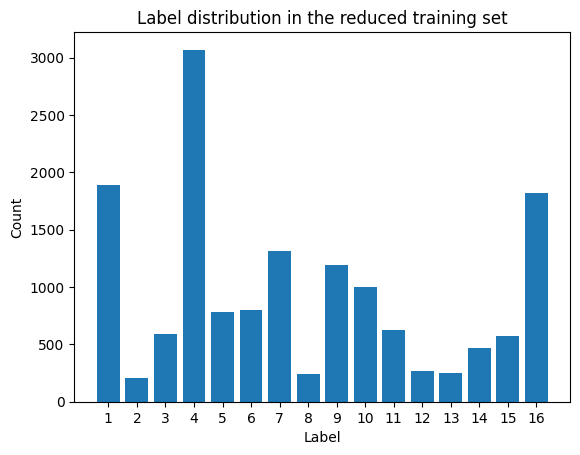

In [8]:
class_occurences_train = (np.bincount([int(x) for x in labels_reduced]))[1:]
classes = sorted([int(x) for x in np.unique(labels_reduced)])

# Plot the label distribution in the training set
plt.figure()
plt.bar(classes, class_occurences_train)
plt.xticks(classes)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Label distribution in the reduced training set")
plt.show()

## 1 - Document Preprocessing

You should use a pre-processing function you can apply to the raw text before any other processing (_i.e_, tokenization and obtaining representations). Some pre-processing can also be tied with the tokenization (_i.e_, removing stop words). Complete the following function, using the appropriate `nltk` tools.

<div class='alert alert-block alert-info'>
            Code:</div>


In [9]:
# Imports
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

<div class='alert alert-block alert-info'>
            Code:</div>


In [10]:
def pre_processing(text):
    stemmer = SnowballStemmer("french")

    # lower case
    text = text.lower()
    # remove numbers
    text = re.sub(r"[0-9]+", "", text)
    # remove punctuation
    REMOVE_PUNCT = re.compile('[.;:!?,"()\[\]-]')
    text = REMOVE_PUNCT.sub("", text)
    # remove the article l' and d'
    text = re.sub(r"\s(l|d)(\’|\')", " ", text)
    # remove all other occurences of apostrophe
    text = re.sub(r"[\'\’]", "", text)
    text = text.split(" ")
    # remove excess space
    text = [x for x in text if len(x) > 0]
    sw = stopwords.words("french")
    text = [x for x in text if x not in sw]
    text = " ".join(stemmer.stem(x) for x in text)

    return text

In [11]:
# Look at the data and apply the appropriate pre-processing
print(f"Original sample: {texts_reduced[0]}")
cleaned_texts_reduced = [pre_processing(text) for text in texts_reduced]
cleaned_test_texts = [pre_processing(text) for text in test_texts]
print(f"Processed sample: {cleaned_texts_reduced[0]}")

Original sample: Mention Analyse et politique économique (APE)
Processed sample: mention analys polit économ ape


Now that the data is cleaned, the first step we will follow is to pick a common vocabulary that we will use for every representations we obtain in this lab. **Use the code of the previous lab to create a vocabulary.**

<div class='alert alert-block alert-info'>
            Code:</div>


In [12]:
from nltk.tokenize import word_tokenize


def count_words(text):
    """Vectorize text : return count of each word in the text snippets
    Parameters
    ----------
    texts : list of str
        The texts
    Returns
    -------
    vocabulary : dict
        A dictionary that points to an index in counts for each word.
    counts : ndarray, shape (n_samples, n_features)
        The counts of each word in each text.
    """

    # process the text and tokenize
    tokenized_text = [
        word_tokenize(pre_processing(text), language="french") for text in texts_reduced
    ]

    # flatten the list
    cleaned_text = [item for sublist in tokenized_text for item in sublist]

    vocabulary_set = set(cleaned_text)
    vocabulary = {word: i for i, word in enumerate(vocabulary_set)}
    counts = np.zeros((len(texts_reduced), len(vocabulary)), dtype=int)

    for i, text in enumerate(tokenized_text):
        for word in text:
            if word in vocabulary:
                counts[i, vocabulary[word]] += 1

    return vocabulary, counts

In [13]:
vocab, counts = count_words(texts_reduced)
print("Length of the vocabulary: ", len(vocab))

Length of the vocabulary:  3459


<div class='alert alert-block alert-warning'>
            Question:</div>

What do you think is the **appropriate vocabulary size here** ? Would any further pre-processing make sense ? Motivate your answer.


<div class='alert alert-block alert-success'>
            Answer:</div>

Following the Zipf's law, we decided to keep the most frequent words in the vocabulary.
We decided to keep words useful for capturing most of the meaning of the whole corpus.

We could have kept more words, but we would have had to deal with a lot of words that appear only once in the whole dataset. This would have made the representations less reliable.


In [14]:
# sort the words by frequency
word_freq = np.sum(counts, axis=0)
sorted_word_freq = np.sort(word_freq)[::-1]
# compute the cumulative sum of the frequencies
cumsum = np.cumsum(sorted_word_freq)
# find the index of the threshold
threshold = 0.95 * cumsum[-1]
idx = np.argmax(cumsum > threshold)

minimal_freq = sorted_word_freq[idx]

print(f"Number of words needed to reach 95% of the total frequency: {idx}")
print(f"Minimum frequency of the top-{idx} words: {minimal_freq}")

Number of words needed to reach 95% of the total frequency: 1075
Minimum frequency of the top-1075 words: 7


In [15]:
# remove the words that are too rare
vocab_filtered = {word: i for word, i in vocab.items() if word_freq[i] >= minimal_freq}
# reindex the vocabulary
vocab = {word: i for i, (word, _) in enumerate(vocab_filtered.items())}
# add UNK token
vocab["UNK"] = len(vocab)

In [16]:
print(vocab)
print("Length of the reduced vocabulary: ", len(vocab))

{'silico': 0, 'air': 1, 'audt': 2, 'climatspécial': 3, 'logiciel': 4, 'organis': 5, 'géoscienc': 6, 'auxiliair': 7, 'qhse': 8, 'santément': 9, 'bioproduct': 10, 'assain': 11, 'innov': 12, 'rest': 13, 'brevet': 14, 'électrotechn': 15, 'vitivinicol': 16, 'anim': 17, 'min': 18, 'miag': 19, 'infograph': 20, 'educ': 21, 'glac': 22, 'virolog': 23, 'diplôm': 24, 'sant': 25, 'écologieenviron': 26, 'mar': 27, 'économ': 28, 'ateli': 29, 'menuisi': 30, 'econom': 31, 'prévent': 32, 'ile': 33, 'social': 34, 'natat': 35, 'pharmacolog': 36, 'escrim': 37, 'dynam': 38, 'horticol': 39, 'po': 40, 'traduct': 41, 'motocycl': 42, 'rpi': 43, 'terroir': 44, 'cycl': 45, 'architectural': 46, 'commerc': 47, 'hospitali': 48, 'hôteller': 49, 'commercialis': 50, 'emploi': 51, 'plasm': 52, 'protect': 53, '”': 54, 'contenti': 55, 'gros': 56, 'régional': 57, 'spiritu': 58, 'défens': 59, 'synthes': 60, 'chain': 61, 'ouest': 62, 'perform': 63, 'écosystem': 64, 'enfanc': 65, 'laiti': 66, 'jeanfrançois': 67, 'intranet/int

## 2 - Symbolic text representations

We can use the `CountVectorizer` class from scikit-learn to obtain the first set of representations:

- Use the appropriate argument to get your own vocabulary
- Fit the vectorizer on your training data, transform your test data
- Create a `LogisticRegression` model and train it with these representations. Display the confusion matrix using functions from `sklearn.metrics`

Then, re-execute the same pipeline with the `TfidfVectorizer`.

<div class='alert alert-block alert-info'>
            Code:</div>


In [17]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

count_vectorizer = CountVectorizer(vocabulary=vocab)
texts_vectorized = count_vectorizer.transform(cleaned_texts_reduced)
test_texts_vectorized = count_vectorizer.transform(cleaned_test_texts)

logistic_cv = LogisticRegression(max_iter=10000)

logistic_cv.fit(texts_vectorized, labels_reduced)
predictions_cv = logistic_cv.predict(test_texts_vectorized)
cm = confusion_matrix(test_labels, predictions_cv)

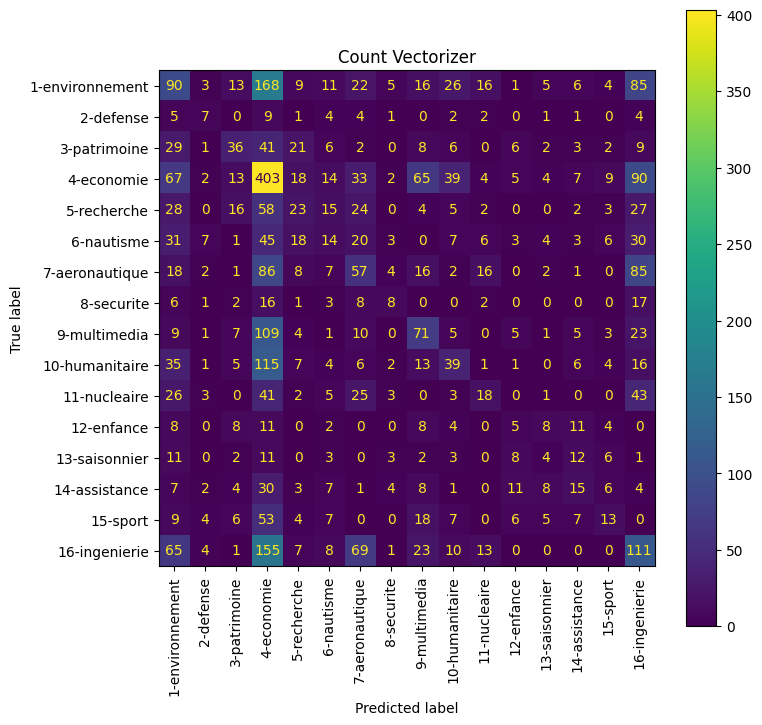

In [18]:
conf_mat_disp = ConfusionMatrixDisplay(cm, display_labels=Categories)
fig, ax = plt.subplots(figsize=(8, 8))
conf_mat_disp.plot(ax=ax, xticks_rotation=90)
plt.title("Count Vectorizer")
plt.show()

In [19]:
print(f"Accuracy: {np.sum(np.diag(cm)) / np.sum(cm)}")

# Print the classification report
print(classification_report(test_labels, predictions_cv, target_names=Categories))

Accuracy: 0.24224754836999735
                 precision    recall  f1-score   support

1-environnement       0.20      0.19      0.19       480
      2-defense       0.18      0.17      0.18        41
   3-patrimoine       0.31      0.21      0.25       172
     4-economie       0.30      0.52      0.38       775
    5-recherche       0.18      0.11      0.14       207
     6-nautisme       0.13      0.07      0.09       198
 7-aeronautique       0.20      0.19      0.19       305
     8-securite       0.22      0.12      0.16        64
   9-multimedia       0.28      0.28      0.28       254
 10-humanitaire       0.25      0.15      0.19       255
   11-nucleaire       0.23      0.11      0.14       170
     12-enfance       0.10      0.07      0.08        69
  13-saisonnier       0.09      0.06      0.07        66
  14-assistance       0.19      0.14      0.16       111
       15-sport       0.22      0.09      0.13       139
  16-ingenierie       0.20      0.24      0.22       467


In [20]:
tfidf_vectorizer = TfidfVectorizer(vocabulary=vocab)
tfidf_vectorizer.fit(cleaned_texts_reduced)
tfidf_vectorizer.set_params(vocabulary=vocab)
texts_vectorized = tfidf_vectorizer.transform(cleaned_texts_reduced)

test_texts_vectorized = tfidf_vectorizer.transform(cleaned_test_texts)
logistic_tfidf = LogisticRegression(max_iter=10000)

logistic_tfidf.fit(texts_vectorized, labels_reduced)
predictions_tfidf = logistic_tfidf.predict(test_texts_vectorized)
cm = confusion_matrix(test_labels, predictions_tfidf)

/home/aldo/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


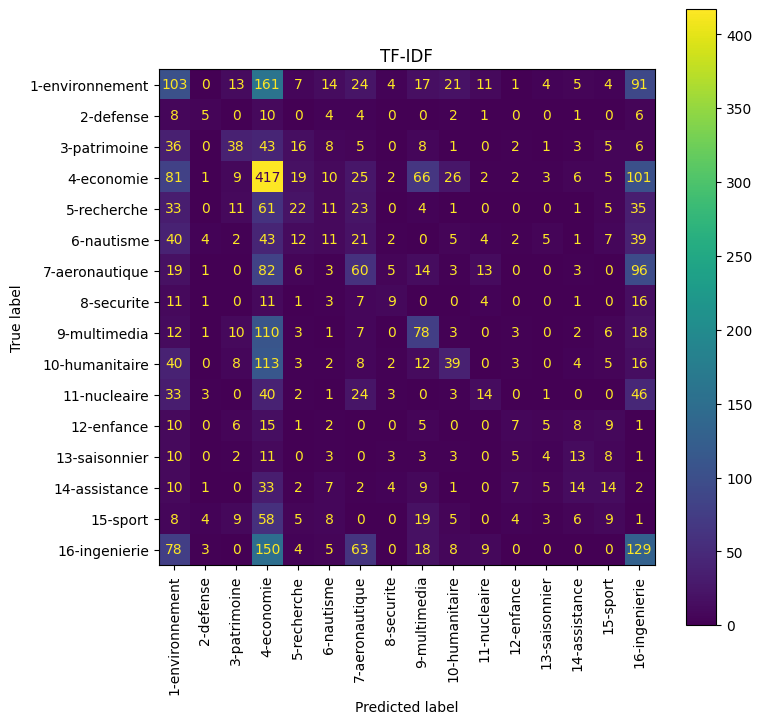

In [21]:
conf_mat_disp = ConfusionMatrixDisplay(cm, display_labels=Categories)
fig, ax = plt.subplots(figsize=(8, 8))
conf_mat_disp.plot(ax=ax, xticks_rotation=90)
plt.title("TF-IDF")
plt.show()

In [22]:
print(f"Accuracy: {np.sum(np.diag(cm)) / np.sum(cm)}")

# Print the classification report
print(classification_report(test_labels, predictions_tfidf, target_names=Categories))

Accuracy: 0.2541743970315399
                 precision    recall  f1-score   support

1-environnement       0.19      0.21      0.20       480
      2-defense       0.21      0.12      0.15        41
   3-patrimoine       0.35      0.22      0.27       172
     4-economie       0.31      0.54      0.39       775
    5-recherche       0.21      0.11      0.14       207
     6-nautisme       0.12      0.06      0.08       198
 7-aeronautique       0.22      0.20      0.21       305
     8-securite       0.26      0.14      0.18        64
   9-multimedia       0.31      0.31      0.31       254
 10-humanitaire       0.32      0.15      0.21       255
   11-nucleaire       0.24      0.08      0.12       170
     12-enfance       0.19      0.10      0.13        69
  13-saisonnier       0.13      0.06      0.08        66
  14-assistance       0.21      0.13      0.16       111
       15-sport       0.12      0.06      0.08       139
  16-ingenierie       0.21      0.28      0.24       467



## 3 - Dense Representations from Topic Modeling

Now, the goal is to re-use the bag-of-words representations we obtained earlier - but reduce their dimension through a **topic model**. Note that this allows to obtain reduced **document representations**, which we can again use directly to perform classification.

- Do this with two models: `TruncatedSVD` and `LatentDirichletAllocation`
- Pick $300$ as the dimensionality of the latent representation (_i.e_, the number of topics)

<div class='alert alert-block alert-info'>
            Code:</div>


In [23]:
count_vectorizer = CountVectorizer(vocabulary=vocab)
texts_vectorized = count_vectorizer.fit_transform(cleaned_texts_reduced)
test_texts_vectorized = count_vectorizer.transform(cleaned_test_texts)

/home/aldo/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1381: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


In [24]:
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation

svd = TruncatedSVD(n_components=300)
lda = LatentDirichletAllocation(n_components=300)

texts_topic_svd = svd.fit_transform(texts_vectorized)
test_texts_topic_svd = svd.transform(test_texts_vectorized)

texts_topic_lda = lda.fit_transform(texts_vectorized)
test_texts_topic_lda = lda.transform(test_texts_vectorized)

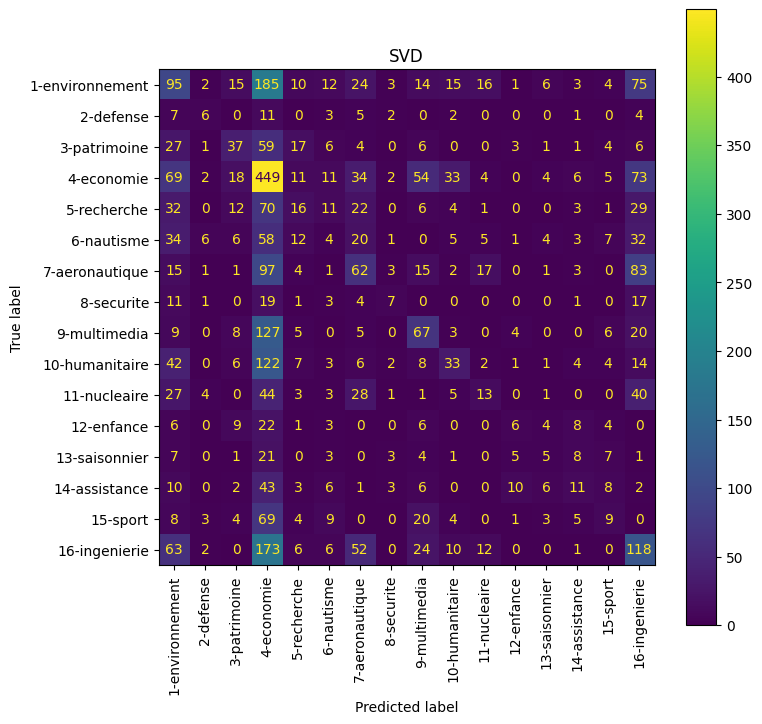

In [25]:
logistic_svd = LogisticRegression(max_iter=10000)

logistic_svd.fit(texts_topic_svd, labels_reduced)
predictions_svd = logistic_svd.predict(test_texts_topic_svd)
cm_svd = confusion_matrix(test_labels, predictions_svd)

conf_mat_disp = ConfusionMatrixDisplay(cm_svd, display_labels=Categories)
fig, ax = plt.subplots(figsize=(8, 8))
conf_mat_disp.plot(ax=ax, xticks_rotation=90)
plt.title("SVD")
plt.show()

In [26]:
print(f"Accuracy: {np.sum(np.diag(cm_svd)) / np.sum(cm_svd)}")

# Print the classification report
print(classification_report(test_labels, predictions_svd, target_names=Categories))

Accuracy: 0.24860853432282004
                 precision    recall  f1-score   support

1-environnement       0.21      0.20      0.20       480
      2-defense       0.21      0.15      0.17        41
   3-patrimoine       0.31      0.22      0.25       172
     4-economie       0.29      0.58      0.38       775
    5-recherche       0.16      0.08      0.10       207
     6-nautisme       0.05      0.02      0.03       198
 7-aeronautique       0.23      0.20      0.22       305
     8-securite       0.26      0.11      0.15        64
   9-multimedia       0.29      0.26      0.28       254
 10-humanitaire       0.28      0.13      0.18       255
   11-nucleaire       0.19      0.08      0.11       170
     12-enfance       0.19      0.09      0.12        69
  13-saisonnier       0.14      0.08      0.10        66
  14-assistance       0.19      0.10      0.13       111
       15-sport       0.15      0.06      0.09       139
  16-ingenierie       0.23      0.25      0.24       467


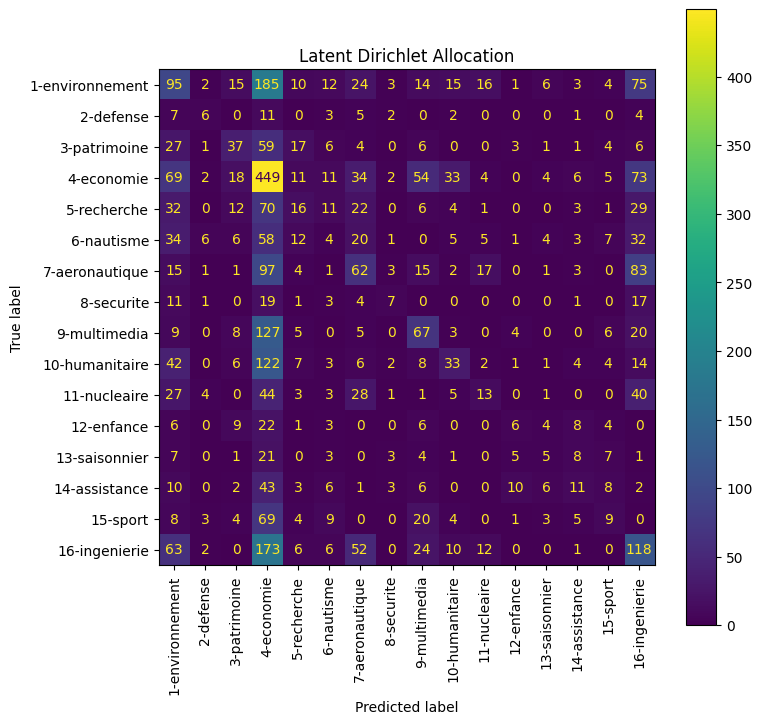

In [27]:
logistic_lda = LogisticRegression(max_iter=10000)

logistic_lda.fit(texts_topic_lda, labels_reduced)
predictions_lda = logistic_lda.predict(test_texts_topic_lda)
cm_lda = confusion_matrix(test_labels, predictions_lda)

conf_mat_disp = ConfusionMatrixDisplay(cm_svd, display_labels=Categories)
fig, ax = plt.subplots(figsize=(8, 8))
conf_mat_disp.plot(ax=ax, xticks_rotation=90)
plt.title("Latent Dirichlet Allocation")
plt.show()

In [28]:
print(f"Accuracy: {np.sum(np.diag(cm_lda)) / np.sum(cm_lda)}")

# Print the classification report
print(classification_report(test_labels, predictions_lda, target_names=Categories))

Accuracy: 0.2504638218923933
                 precision    recall  f1-score   support

1-environnement       0.21      0.25      0.23       480
      2-defense       0.00      0.00      0.00        41
   3-patrimoine       0.25      0.15      0.18       172
     4-economie       0.27      0.65      0.39       775
    5-recherche       0.11      0.02      0.04       207
     6-nautisme       0.12      0.05      0.07       198
 7-aeronautique       0.24      0.20      0.22       305
     8-securite       0.36      0.08      0.13        64
   9-multimedia       0.33      0.21      0.25       254
 10-humanitaire       0.47      0.07      0.12       255
   11-nucleaire       0.37      0.06      0.10       170
     12-enfance       0.33      0.07      0.12        69
  13-saisonnier       0.13      0.03      0.05        66
  14-assistance       0.20      0.01      0.02       111
       15-sport       0.12      0.05      0.07       139
  16-ingenierie       0.22      0.27      0.24       467



/home/aldo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aldo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aldo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<div class='alert alert-block alert-warning'>
            Question:</div>
            
We picked $300$ as number of topics. What would be the procedure to follow if we wanted to choose this hyperparameter through the data ?


<div class='alert alert-block alert-success'>
            Question:</div>

We could use a grid search (Cross validation) to find the best number of topics or we could also use the elbow method to find the best number of topics.


## 4 - Dense Count-based Representations

The following function allows to obtain very large-dimensional vectors for **words**. We will now follow a different procedure:

- Step 1: Obtain the co-occurence matrix, based on the vocabulary, giving you a vector by word in the vocabulary.
- Step 2: Apply an SVD to obtain **word embeddings** of dimension $300$, for each word in the vocabulary.
- Step 3: Obtain document representations by aggregating embeddings associated to each word in the document.
- Step 4: Train a classifier on the (document representations, label) pairs.

Some instructions:

- In step 1, use the `co_occurence_matrix` function, which you need to complete.
- In step 2, use `TruncatedSVD` to obtain word representations of dimension $300$ from the output of the `co_occurence_matrix` function.
- In step 3, use the `sentence_representations` function, which you will need to complete.
- In step 4, put the pipeline together by obtaining document representations for both training and testing data. Careful: the word embeddings must come from the _training data co-occurence matrix_ only.

Lastly, add a **Step 1b**: transform the co-occurence matrix into the PPMI matrix, and compare the results.


In [29]:
def co_occurence_matrix(corpus, vocabulary, window=0):
    """
    Params:
        corpus (list of list of strings): corpus of sentences
        vocabulary (dictionary): words to use in the matrix
        window (int): size of the context window; when 0, the context is the whole sentence
    Returns:
        matrix (array of size (len(vocabulary), len(vocabulary))): the co-oc matrix, using the same ordering as the vocabulary given in input
    """
    l = len(vocabulary)
    M = np.zeros((l, l))

    for sent in corpus:
        # Obtain the indexes of the words in the sentence from the vocabulary
        sent_idx = [vocabulary.get(word, l - 1) for word in sent]

        # Avoid one-word sentences - can create issues in normalization:
        if len(sent_idx) == 1:
            sent_idx.append(
                len(vocabulary) - 1
            )  # This adds an Unkown word to the sentence

        # Go through the indexes and add 1 / dist(i,j) to M[i,j] if words of index i and j appear in the same window
        for _, idx in enumerate(sent_idx):
            # If we consider a limited context:
            if window > 0:
                # Create a list containing the indexes that are on the left of the current index 'idx_i'
                l_ctx_idx = sent_idx[max(idx - window, 0) : idx]
            # If the context is the entire document:
            else:
                # The list containing the left context is easier to create
                l_ctx_idx = sent_idx[:idx]

            # Go through the list and update M[i,j] and M[j,i]:
            for _, ctx_idx in enumerate(l_ctx_idx):
                M[ctx_idx, idx] = M[idx, ctx_idx] = M[ctx_idx, idx] + 1
    return M

<div class='alert alert-block alert-info'>
            Code:</div>


In [30]:
# Obtain the co-occurence matrix, transform it as needed, reduce its dimension
cooc_matrix = co_occurence_matrix([t.split(" ") for t in cleaned_texts_reduced], vocab)
matrix_svd = TruncatedSVD(n_components=300)
word_embeddings = matrix_svd.fit_transform(cooc_matrix)

<div class='alert alert-block alert-info'>
            Code:</div>


In [31]:
def sentence_representations(texts, vocabulary, embeddings, np_func=np.mean):
    """
    Represent the sentences as a combination of the vector of its words.
    Parameters
    ----------
    texts : a list of sentences
    vocabulary : dict
        From words to indexes of vector.
    embeddings : Matrix containing word representations
    np_func : function (default: np.sum)
        A numpy matrix operation that can be applied columnwise,
        like `np.mean`, `np.sum`, or `np.prod`.
    Returns
    -------
    np.array, dimension `(len(texts), embeddings.shape[1])`
    """
    representations = []

    for text in texts:
        # Indexes of words in the sentence obtained thanks to the vocabulary
        indexes = [
            vocabulary[x] if x in vocabulary else vocabulary["UNK"]
            for x in text.split(" ")
        ]
        # Embeddings of words in the sentence, aggregated thanks to the function
        sentrep = np_func(np.array([embeddings[index, :] for index in indexes]), axis=0)
        representations.append(sentrep)

    representations = np.array(representations)
    return representations

<div class='alert alert-block alert-info'>
            Code:</div>


In [32]:
# Obtain document representations, apply the classifier
train_representations = sentence_representations(
    cleaned_texts_reduced, vocab, word_embeddings
)
test_representations = sentence_representations(
    cleaned_test_texts, vocab, word_embeddings
)

/home/aldo/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


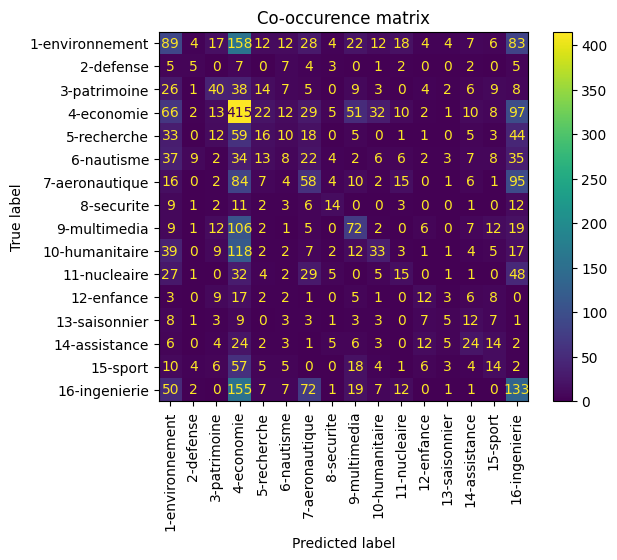

In [33]:
logistic_cooc = LogisticRegression(max_iter=10000)

logistic_cooc.fit(train_representations, labels_reduced)
predictions_cooc = logistic_cooc.predict(test_representations)
cm_cooc = confusion_matrix(test_labels, predictions_cooc)

ConfusionMatrixDisplay(cm_cooc, display_labels=Categories).plot(xticks_rotation=90)
plt.title("Co-occurence matrix")
plt.show()

In [34]:
print(f"Accuracy: {np.sum(np.diag(cm_cooc)) / np.sum(cm_cooc)}")

# Print the classification report
print(classification_report(test_labels, predictions_cooc, target_names=Categories))

Accuracy: 0.2525841505433342
                 precision    recall  f1-score   support

1-environnement       0.21      0.19      0.19       480
      2-defense       0.16      0.12      0.14        41
   3-patrimoine       0.31      0.23      0.26       172
     4-economie       0.31      0.54      0.40       775
    5-recherche       0.15      0.08      0.10       207
     6-nautisme       0.09      0.04      0.06       198
 7-aeronautique       0.20      0.19      0.20       305
     8-securite       0.29      0.22      0.25        64
   9-multimedia       0.31      0.28      0.30       254
 10-humanitaire       0.29      0.13      0.18       255
   11-nucleaire       0.17      0.09      0.12       170
     12-enfance       0.21      0.17      0.19        69
  13-saisonnier       0.17      0.08      0.10        66
  14-assistance       0.23      0.22      0.22       111
       15-sport       0.15      0.10      0.12       139
  16-ingenierie       0.22      0.28      0.25       467



## 5 - Dense Prediction-based Representations

We will now use word embeddings from `Word2Vec`: which we will train ourselves

We will use the `gensim` library for its implementation of word2vec in python. Since we want to keep the same vocabulary as before: we'll first create the model, then re-use the vocabulary we generated above.


In [35]:
from gensim.models import Word2Vec

<div class='alert alert-block alert-info'>
            Code:</div>


In [36]:
# Train the Word2Vec model
model = Word2Vec(
    [text.split(" ") for text in cleaned_texts_reduced],
    vector_size=300,
    window=5,
    min_count=1,
    workers=4,
)

Then, we can re-use the `sentence_representations`function like before to obtain document representations, and apply classification.

<div class='alert alert-block alert-info'>
            Code:</div>


In [37]:
# Get the word embeddings
word_embeddings = model.wv.vectors

# Create the vocabulary
print(vocab)

# Get the document representations
train_representations = sentence_representations(
    cleaned_texts_reduced, vocab, word_embeddings
)
test_representations = sentence_representations(
    cleaned_test_texts, vocab, word_embeddings
)

{'silico': 0, 'air': 1, 'audt': 2, 'climatspécial': 3, 'logiciel': 4, 'organis': 5, 'géoscienc': 6, 'auxiliair': 7, 'qhse': 8, 'santément': 9, 'bioproduct': 10, 'assain': 11, 'innov': 12, 'rest': 13, 'brevet': 14, 'électrotechn': 15, 'vitivinicol': 16, 'anim': 17, 'min': 18, 'miag': 19, 'infograph': 20, 'educ': 21, 'glac': 22, 'virolog': 23, 'diplôm': 24, 'sant': 25, 'écologieenviron': 26, 'mar': 27, 'économ': 28, 'ateli': 29, 'menuisi': 30, 'econom': 31, 'prévent': 32, 'ile': 33, 'social': 34, 'natat': 35, 'pharmacolog': 36, 'escrim': 37, 'dynam': 38, 'horticol': 39, 'po': 40, 'traduct': 41, 'motocycl': 42, 'rpi': 43, 'terroir': 44, 'cycl': 45, 'architectural': 46, 'commerc': 47, 'hospitali': 48, 'hôteller': 49, 'commercialis': 50, 'emploi': 51, 'plasm': 52, 'protect': 53, '”': 54, 'contenti': 55, 'gros': 56, 'régional': 57, 'spiritu': 58, 'défens': 59, 'synthes': 60, 'chain': 61, 'ouest': 62, 'perform': 63, 'écosystem': 64, 'enfanc': 65, 'laiti': 66, 'jeanfrançois': 67, 'intranet/int

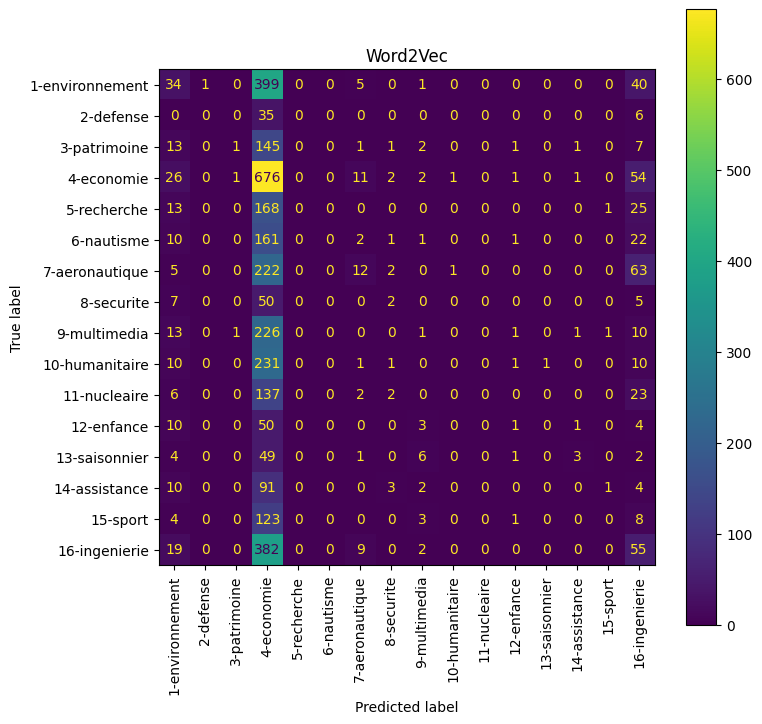

In [38]:
logistic_w2v = LogisticRegression(max_iter=10000)

logistic_w2v.fit(train_representations, labels_reduced)
predictions_w2v = logistic_w2v.predict(test_representations)
cm_w2v = confusion_matrix(test_labels, predictions_w2v)

conf_mat_disp = ConfusionMatrixDisplay(cm_w2v, display_labels=Categories)
fig, ax = plt.subplots(figsize=(8, 8))
conf_mat_disp.plot(ax=ax, xticks_rotation=90)
plt.title("Word2Vec")
plt.show()

In [39]:
print(f"Accuracy: {np.sum(np.diag(cm_w2v)) / np.sum(cm_w2v)}")

# Print the classification report
print(classification_report(test_labels, predictions_w2v, target_names=Categories))

Accuracy: 0.20726212562947258
                 precision    recall  f1-score   support

1-environnement       0.18      0.07      0.10       480
      2-defense       0.00      0.00      0.00        41
   3-patrimoine       0.33      0.01      0.01       172
     4-economie       0.21      0.87      0.34       775
    5-recherche       0.00      0.00      0.00       207
     6-nautisme       0.00      0.00      0.00       198
 7-aeronautique       0.27      0.04      0.07       305
     8-securite       0.14      0.03      0.05        64
   9-multimedia       0.04      0.00      0.01       254
 10-humanitaire       0.00      0.00      0.00       255
   11-nucleaire       0.00      0.00      0.00       170
     12-enfance       0.12      0.01      0.03        69
  13-saisonnier       0.00      0.00      0.00        66
  14-assistance       0.00      0.00      0.00       111
       15-sport       0.00      0.00      0.00       139
  16-ingenierie       0.16      0.12      0.14       467


/home/aldo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aldo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aldo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<div class='alert alert-block alert-warning'>
            Question:</div>
            
Comment on the results. What is the big issue with the dataset that using embeddings did not solve ? 
**Given this type of data**, what would you propose if you needed solve this task (i.e, reach a reasonnable performance) in an industrial context ?


<div class='alert alert-block alert-success'>
            Answer:</div>

The problem is that some classes appear more often than others. For example, category 4 is the most common (as we can see in the plot at the beginning), and it's also the one predicted most often. To fix this, we could try reducing the number of instances of category 4 (and any other classes that are too common).
